## Task Overview
In this experiment, we compare two CNN architectures on the Tiny ImageNet dataset:
1. A custom CNN (baseline)
2. A pretrained ResNet18 (modern deep model)

We evaluate model performance under different optimizers (SGD vs Adam) and learning rate schedulers.
Our analysis includes convergence behavior, accuracy metrics, confusion matrices, and activation map visualizations.


In [1]:
#Load Tiny Imagenet Dataset
#Uncomment and run to download and unzip the data

# !curl https://cs231n.stanford.edu/tiny-imagenet-200.zip
# !unzip -q tiny-imagenet-200.zip 

#### Imports and preliminary setup

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchviz import make_dot
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from tqdm import tqdm
import os
import numpy as np
from torchvision import transforms
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import copy
import pickle
import seaborn as sns

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


#### Data Exploration and Visualization


In [3]:
os.listdir("tiny-imagenet-200")

['wnids.txt', 'train', 'test', 'val', 'words.txt']

In [4]:
with open("tiny-imagenet-200/words.txt") as f:
    words = f.read().strip().split("\n")
    word_dict = {}
    for word in words:
        word_id, word = word.split("\t")
        word_dict[word_id] = word

print(len(word_dict))

82115


In [5]:
random.sample(list(word_dict.items()), 5)

[('n02736396', 'areaway'),
 ('n00646504', 'scatology'),
 ('n06681035', 'carbon process'),
 ('n05855904', 'term'),
 ('n05298159', 'primordium, anlage')]

In [6]:
with open("tiny-imagenet-200/wnids.txt") as f:
    wnids = f.read().strip().split("\n")
print(wnids[:5])
print(len(wnids))

['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582']
200


In [7]:
image_dirs = [os.path.join("tiny-imagenet-200/train", wnid, "images") for wnid in wnids]
image_files = [os.path.join(img_dir, img_file) for img_dir in image_dirs for img_file in os.listdir(img_dir)]
image_files[:5]

['tiny-imagenet-200/train/n02124075/images/n02124075_272.JPEG',
 'tiny-imagenet-200/train/n02124075/images/n02124075_346.JPEG',
 'tiny-imagenet-200/train/n02124075/images/n02124075_94.JPEG',
 'tiny-imagenet-200/train/n02124075/images/n02124075_0.JPEG',
 'tiny-imagenet-200/train/n02124075/images/n02124075_260.JPEG']

(64, 64, 3)


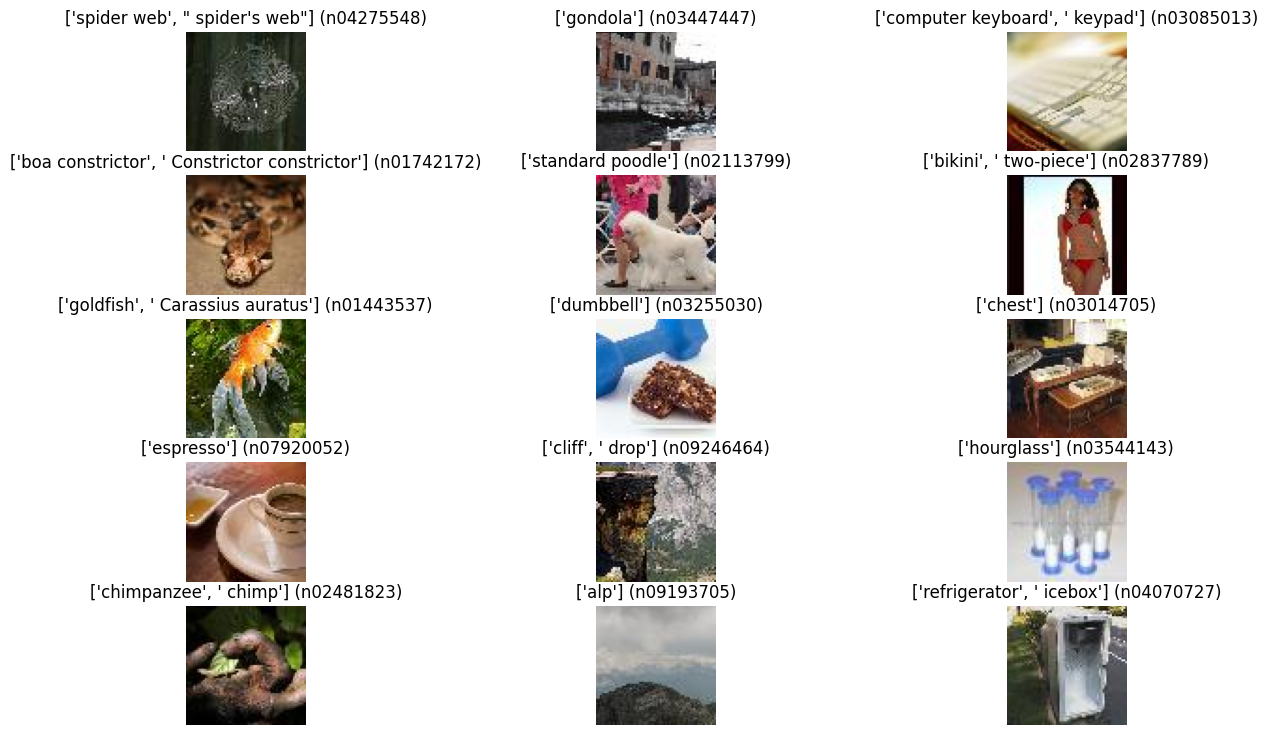

In [8]:
fig, ax = plt.subplots(5, 3, figsize=(15,9))
for i in range(5):
    for j in range(3):
        random_idx = random.randint(0, len(image_files) - 1)
        img_path = image_files[random_idx]
        img = mpimg.imread(img_path)
        ax[i, j].imshow(img)
        ax[i, j].axis('off')
        wnid = img_path.split(os.sep)[-3]
        ax[i, j].set_title(f"{word_dict[wnid].split(',')[:2]} ({wnid})")
       
print(img.shape)  # (64, 64, 3)

#### Dataset Loader and transformations 

In [9]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # Load class list
        wnids_path = os.path.join(root_dir, "wnids.txt")
        with open(wnids_path, "r") as f:
            wnids = [x.strip() for x in f.readlines()]
        self.class_to_idx = {wnid: i for i, wnid in enumerate(wnids)}

        if split == "train":
            self._load_train()
        else:
            self._load_val()

    def _load_train(self):
        train_dir = os.path.join(self.root_dir, "train")
        for wnid in os.listdir(train_dir):
            img_dir = os.path.join(train_dir, wnid, "images")
            if not os.path.isdir(img_dir):
                continue
            for fname in os.listdir(img_dir):
                if fname.endswith(".JPEG"):
                    self.image_paths.append(os.path.join(img_dir, fname))
                    self.labels.append(self.class_to_idx[wnid])

    def _load_val(self):
        val_dir = os.path.join(self.root_dir, "val")
        anno_path = os.path.join(val_dir, "val_annotations.txt")
        img_dir = os.path.join(val_dir, "images")

        # Parse annotations
        annotations = {}
        with open(anno_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split("\t")
                if len(parts) >= 2:
                    annotations[parts[0]] = parts[1]

        for fname in os.listdir(img_dir):
            if fname.endswith(".JPEG") and fname in annotations:
                wnid = annotations[fname]
                if wnid in self.class_to_idx:
                    self.image_paths.append(os.path.join(img_dir, fname))
                    self.labels.append(self.class_to_idx[wnid])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [10]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize((0.480, 0.448, 0.397), (0.277, 0.269, 0.282)),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.25), ratio=(0.3, 3.3))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.480, 0.448, 0.397), (0.277, 0.269, 0.282))
])
train_dataset = TinyImageNetDataset(root_dir="tiny-imagenet-200", split="train", transform=train_transform)
val_dataset = TinyImageNetDataset(root_dir="tiny-imagenet-200", split="val", transform=transforms.ToTensor())

### Models


#### Custom CNN
The custom CNN implementation is inspired from the Yolov1 implementation presented in the Lab 08. 

In [11]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(0.1)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class CustomCNN(nn.Module):
    def __init__(self, architecture_config, in_channels=3, input_size=64, num_classes=200, fc_layers=None, dropout=0.5, **kwargs):
        super(CustomCNN, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.input_size = input_size
        self.num_classes = num_classes
        
        self.network = self._create_conv_layers(self.architecture)
        
        self.fc_layers = fc_layers if fc_layers else [512]
        self.flat_size = self._calculate_flat_size()
        self.dropout = dropout # Dropout for FC layers
        
        self.fcs = self._create_fc_layers(**kwargs)


    def forward(self,x):
        x = self.network(x)
        return self.fcs(torch.flatten(x, start_dim=1))
    
    def _calculate_flat_size(self):
        """Calculate flattened size by passing dummy input through conv layers"""
        dummy_input = torch.zeros(1, self.in_channels, self.input_size, self.input_size)
        dummy_output = self.network(dummy_input)
        return dummy_output.view(1, -1).shape[1]
    
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(in_channels, out_channels = x[1], kernel_size=x[0], stride=x[2], padding=x[3],)]
                in_channels = x[1]

            if type(x) == str:
                layers += [
                    nn.MaxPool2d(kernel_size=2, stride=2)]

            if type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(in_channels, out_channels = conv1[1], kernel_size= conv1[0], stride=conv1[2], padding=conv1[3],)]
                    layers += [
                        CNNBlock(conv1[1], out_channels = conv2[1], kernel_size= conv2[0], stride=conv2[2], padding=conv2[3],)]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)
    
    def _create_fc_layers(self):
        """Build FC layers dynamically based on flat_size and fc_layers config"""
        layers = []
        layer_sizes = [self.flat_size] + self.fc_layers + [self.num_classes]
        
        # Create all layers except the last one with activation and dropout
        for i in range(len(layer_sizes) - 2):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.LeakyReLU(0.1))
            layers.append(nn.Dropout(self.dropout))
        
        # Last layer: no activation (will use with CrossEntropyLoss)
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        
        return nn.Sequential(*layers)

In [12]:

""" 
Information about architecture config:
Tuple is structured by (kernel_size, filters, stride, padding) 
"M" is simply maxpooling with stride 2x2 and kernel 2x2
List is structured by tuples and lastly int with number of repeats
"""


TINY_IMAGENET_ARCH = [
    (3, 64, 1, 1),   # 64x64 -> 64x64
    (3, 64, 1, 1),
    "M",             # 64 -> 32
    (3, 128, 1, 1),
    (3, 128, 1, 1),
    "M",             # 32 -> 16
    (3, 256, 1, 1),
    (3, 256, 1, 1),
    (1, 256, 1, 0),  # bottleneck
    "M",             # 16 -> 8
    (3, 512, 1, 1),
    (1, 512, 1, 0),  # bottleneck
    "M",             # 8 -> 4
]

TINY_IMAGENET_FC_LAYERS = [512, 256]

### ResNet for Tiny ImageNet (64×64)

This implementation is **adapted from [Aladdin Persson’s PyTorch ResNet](https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/CNN_architectures/pytorch_resnet.py)** with modifications for **small images (64×64)**.

#### Key Changes:

1. **First convolution modified**
   * Original: `7x7 kernel, stride=2, padding=3`
   * Updated: `3x3 kernel, stride=1, padding=1`
   * **Reason:** Preserve spatial resolution for 64×64 images; large kernel + stride=2 would shrink feature maps too early.

2. **Initial maxpool removed**
   * Original ResNet uses a `3x3 maxpool, stride=2` after first conv.
   * **Reason:** Tiny images would be downsampled too aggressively, losing critical spatial information needed by early residual blocks.

3. **Number of classes default set to 200**
   * Original: 1000 (ImageNet)
   * Updated: 200 (Tiny ImageNet dataset)

#### Feature Map Size Comparision Original vs Modified

| Layer / Stage         | Original ResNet (224×224 input) | Modified ResNet (Tiny ImageNet 64×64) |
| --------------------- | ------------------------------- | ------------------------------------- |
| **Conv1**             | 7×7, stride=2 → 112×112         | 3×3, stride=1 → 64×64                 |
| **MaxPool**           | 3×3, stride=2 → 56×56           | **Removed** → 64×64                   |
| **Layer1 (stride=1)** | 56×56                           | 64×64                                 |
| **Layer2 (stride=2)** | 28×28                           | 32×32                                 |
| **Layer3 (stride=2)** | 14×14                           | 16×16                                 |
| **Layer4 (stride=2)** | 7×7                             | 8×8                                   |
| **AvgPool**           | 1×1                             | 1×1                                   |
| **Fully Connected**   | 1000 classes                    | 200 classes (Tiny ImageNet)           |


#### Effect of Changes:

* Maintains higher spatial resolution in early layers → better feature extraction for small images.
* Ensures compatibility with Tiny ImageNet images (64×64) without modifying the overall ResNet architecture.




In [13]:
class Block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        if self.identity_downsample:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super().__init__()
        self.in_channels = 64
        # Modify first conv for 64x64 images
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        # Remove initial maxpool
        self.layer1 = self._make_layer(block, layers[0], 64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], 128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], 256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], 512, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def _make_layer(self, block, num_blocks, intermediate_channels, stride):
        identity_downsample = None
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, intermediate_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(intermediate_channels * 4)
            )
        layers = [block(self.in_channels, intermediate_channels, identity_downsample, stride)]
        self.in_channels = intermediate_channels * 4
        for _ in range(num_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))
        return nn.Sequential(*layers)

def ResNet50(img_channel=3, num_classes=200):
    return ResNet(Block, [3, 4, 6, 3], img_channel, num_classes)

def ResNet101(img_channel=3, num_classes=200):
    return ResNet(Block, [3, 4, 23, 3], img_channel, num_classes)


#### Train Function with Early Stopping

In [14]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None,
                num_epochs=5, device='cuda', early_stopping_patience=5, model_name=None,
                save_dir="checkpoints"):

    os.makedirs(save_dir, exist_ok=True)

    train_losses, val_losses = [], []
    early_stopper = EarlyStopping(patience=early_stopping_patience)
    if torch.cuda.device_count() > 1:
        print(f"🧠 Using {torch.cuda.device_count()} GPUs!")
        model = torch.nn.DataParallel(model)
    model.to(device)
    # Use provided name or fallback to model class name
    model_name = model_name or model.__class__.__name__
    best_model_path = os.path.join(save_dir, f"best_{model_name}.pth")

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        model.train()
        running_loss = 0.0

        # --- Training Loop ---
        train_pbar = tqdm(train_loader, desc='Training', leave=False)
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_pbar.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- Validation Loop ---
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0

        val_pbar = tqdm(val_loader, desc='Validating', leave=False)
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * correct / total

        # --- Scheduler Step ---
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.2f}% | "
              f"LR: {current_lr:.6f}")

        # --- Save Best Model ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"💾 Saved best model so far: {best_model_path}")

        # --- Early Stopping Check ---
        early_stopper(avg_val_loss)
        if early_stopper.early_stop:
            print(f"⏹️ Early stopping triggered after {epoch+1} epochs.")
            break

    print("Training complete!")
    print(f"✅ Best model saved at: {best_model_path}")
    return train_losses, val_losses

#### Experiments with the models

In [16]:
# ========================
# EXPERIMENT CONFIGURATION
# ========================
batch_size = 128       # more stable training and fits GPU memory for ResNet
num_epochs = 15        # faster runs, still long enough for convergence
learning_rate = 0.001  # good baseline; works well for both Adam and SGD
early_stopping_patience = 4  # early stopping to save time
weight_decay = 1e-4    # standard for both Adam/SGD
momentum = 0.9


In [17]:
# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [18]:
optimizers = {
    "SGD": lambda model: torch.optim.SGD(
        model.parameters(),
        lr=learning_rate,
        momentum=momentum,
        weight_decay=weight_decay,
        nesterov=True
    ),
    "Adam": lambda model: torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
}

schedulers = {
    "None": lambda optimizer: None, 
    "StepLR": lambda optimizer: torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=4, gamma=0.3
    ),
    "ReduceLROnPlateau": lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, patience=2
    )
}
criterion = nn.CrossEntropyLoss()



##### Loading Models
Here we use pretrained ResNet50 weights for the unmodified layers

In [19]:
model_cnn = CustomCNN(
    architecture_config=TINY_IMAGENET_ARCH,
    in_channels=3,
    input_size=64,
    num_classes=200,
    fc_layers=TINY_IMAGENET_FC_LAYERS
)

pretrained_resnet = models.resnet50(weights="IMAGENET1K_V1")

model_resnet = ResNet50(img_channel=3, num_classes=200)

pretrained_dict = pretrained_resnet.state_dict()
resnet_dict = model_resnet.state_dict()

pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in resnet_dict and "conv1" not in k and "fc" not in k}
resnet_dict.update(pretrained_dict)
model_resnet.load_state_dict(resnet_dict)

<All keys matched successfully>

In [20]:
# Evaluation Function for Comparision Later

def evaluate_model(model, data_loader, device='cuda'):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    return accuracy, np.array(all_preds), np.array(all_labels)

In [21]:
results = {}

for model_name, base_model in [("CustomCNN", model_cnn), ("ResNet50", model_resnet)]:
    for opt_name, opt_func in optimizers.items():
        for sched_name, sched_func in schedulers.items():
            
            # make a fresh copy of the model
            model = copy.deepcopy(base_model)
            optimizer = opt_func(model)
            scheduler = sched_func(optimizer)

            combo_name = f"{model_name}_{opt_name}_{sched_name}"
            print(f"Training: {combo_name}")

            train_losses, val_losses = train_model(
                model, train_loader, val_loader,
                criterion, optimizer, scheduler,
                num_epochs=num_epochs, device=device,
                model_name=combo_name,
                early_stopping_patience=early_stopping_patience
            )

            train_acc, _, _ = evaluate_model(model, train_loader, device)
            val_acc, val_preds, val_labels = evaluate_model(model, val_loader, device)

            results[combo_name] = {
                "train_losses": train_losses,
                "val_losses": val_losses,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_preds": val_preds,
                "val_labels": val_labels,
                "model": model
            }

            torch.cuda.empty_cache()


Training: CustomCNN_SGD_None
🧠 Using 4 GPUs!

Epoch [1/15]


Epoch [1/15] Train Loss: 5.2782 | Val Loss: 5.2847 | Val Acc: 0.74% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_CustomCNN_SGD_None.pth

Epoch [2/15]


Epoch [2/15] Train Loss: 5.1382 | Val Loss: 5.3125 | Val Acc: 0.83% | LR: 0.001000

Epoch [3/15]


Epoch [3/15] Train Loss: 4.9197 | Val Loss: 5.3757 | Val Acc: 1.13% | LR: 0.001000

Epoch [4/15]


Epoch [4/15] Train Loss: 4.7071 | Val Loss: 5.3255 | Val Acc: 1.46% | LR: 0.001000

Epoch [5/15]


Epoch [5/15] Train Loss: 4.5311 | Val Loss: 5.4183 | Val Acc: 1.35% | LR: 0.001000
⏹️ Early stopping triggered after 5 epochs.
Training complete!
✅ Best model saved at: checkpoints/best_CustomCNN_SGD_None.pth


Training: CustomCNN_SGD_StepLR
🧠 Using 4 GPUs!

Epoch [1/15]


Epoch [1/15] Train Loss: 5.2790 | Val Loss: 5.2928 | Val Acc: 0.59% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_CustomCNN_SGD_StepLR.pth

Epoch [2/15]


Epoch [2/15] Train Loss: 5.1290 | Val Loss: 5.3208 | Val Acc: 0.84% | LR: 0.001000

Epoch [3/15]


Epoch [3/15] Train Loss: 4.9079 | Val Loss: 5.4189 | Val Acc: 1.06% | LR: 0.001000

Epoch [4/15]


Epoch [4/15] Train Loss: 4.6941 | Val Loss: 5.4435 | Val Acc: 1.44% | LR: 0.000300

Epoch [5/15]


Epoch [5/15] Train Loss: 4.5330 | Val Loss: 5.3817 | Val Acc: 1.58% | LR: 0.000300
⏹️ Early stopping triggered after 5 epochs.
Training complete!
✅ Best model saved at: checkpoints/best_CustomCNN_SGD_StepLR.pth


Training: CustomCNN_SGD_ReduceLROnPlateau
🧠 Using 4 GPUs!

Epoch [1/15]


Epoch [1/15] Train Loss: 5.2724 | Val Loss: 5.2823 | Val Acc: 0.81% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_CustomCNN_SGD_ReduceLROnPlateau.pth

Epoch [2/15]


Epoch [2/15] Train Loss: 5.1218 | Val Loss: 5.2917 | Val Acc: 1.17% | LR: 0.001000

Epoch [3/15]


Epoch [3/15] Train Loss: 4.9082 | Val Loss: 5.3376 | Val Acc: 1.01% | LR: 0.001000

Epoch [4/15]


Epoch [4/15] Train Loss: 4.6952 | Val Loss: 5.2573 | Val Acc: 1.30% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_CustomCNN_SGD_ReduceLROnPlateau.pth

Epoch [5/15]


Epoch [5/15] Train Loss: 4.5153 | Val Loss: 5.2260 | Val Acc: 1.89% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_CustomCNN_SGD_ReduceLROnPlateau.pth

Epoch [6/15]


Epoch [6/15] Train Loss: 4.3558 | Val Loss: 5.2185 | Val Acc: 1.71% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_CustomCNN_SGD_ReduceLROnPlateau.pth

Epoch [7/15]


Epoch [7/15] Train Loss: 4.2148 | Val Loss: 5.3546 | Val Acc: 2.08% | LR: 0.001000

Epoch [8/15]


Epoch [8/15] Train Loss: 4.0771 | Val Loss: 5.1131 | Val Acc: 3.45% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_CustomCNN_SGD_ReduceLROnPlateau.pth

Epoch [9/15]


Epoch [9/15] Train Loss: 3.9598 | Val Loss: 5.3284 | Val Acc: 3.06% | LR: 0.001000

Epoch [10/15]


Epoch [10/15] Train Loss: 3.8601 | Val Loss: 5.3090 | Val Acc: 2.55% | LR: 0.001000

Epoch [11/15]


Epoch [11/15] Train Loss: 3.7737 | Val Loss: 5.3144 | Val Acc: 2.56% | LR: 0.000500

Epoch [12/15]


Epoch [12/15] Train Loss: 3.6677 | Val Loss: 5.2187 | Val Acc: 3.30% | LR: 0.000500
⏹️ Early stopping triggered after 12 epochs.
Training complete!
✅ Best model saved at: checkpoints/best_CustomCNN_SGD_ReduceLROnPlateau.pth


Training: CustomCNN_Adam_None
🧠 Using 4 GPUs!

Epoch [1/15]


Epoch [1/15] Train Loss: 5.1687 | Val Loss: 5.4879 | Val Acc: 0.99% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_CustomCNN_Adam_None.pth

Epoch [2/15]


Epoch [2/15] Train Loss: 4.8425 | Val Loss: 5.0882 | Val Acc: 2.31% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_CustomCNN_Adam_None.pth

Epoch [3/15]


Epoch [3/15] Train Loss: 4.5006 | Val Loss: 5.2883 | Val Acc: 2.32% | LR: 0.001000

Epoch [4/15]


Epoch [4/15] Train Loss: 4.2096 | Val Loss: 5.8179 | Val Acc: 1.53% | LR: 0.001000

Epoch [5/15]


Epoch [5/15] Train Loss: 4.0267 | Val Loss: 5.8364 | Val Acc: 1.53% | LR: 0.001000

Epoch [6/15]


Epoch [6/15] Train Loss: 3.9004 | Val Loss: 5.0410 | Val Acc: 4.23% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_CustomCNN_Adam_None.pth

Epoch [7/15]


Epoch [7/15] Train Loss: 3.7916 | Val Loss: 5.2686 | Val Acc: 4.33% | LR: 0.001000

Epoch [8/15]


Epoch [8/15] Train Loss: 3.6968 | Val Loss: 5.3857 | Val Acc: 3.89% | LR: 0.001000

Epoch [9/15]


Epoch [9/15] Train Loss: 3.6103 | Val Loss: 5.5273 | Val Acc: 3.50% | LR: 0.001000

Epoch [10/15]


Epoch [10/15] Train Loss: 3.5366 | Val Loss: 5.5199 | Val Acc: 3.95% | LR: 0.001000
⏹️ Early stopping triggered after 10 epochs.
Training complete!
✅ Best model saved at: checkpoints/best_CustomCNN_Adam_None.pth


Training: CustomCNN_Adam_StepLR
🧠 Using 4 GPUs!

Epoch [1/15]


Epoch [1/15] Train Loss: 5.1714 | Val Loss: 5.3007 | Val Acc: 0.84% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_CustomCNN_Adam_StepLR.pth

Epoch [2/15]


Epoch [2/15] Train Loss: 4.8977 | Val Loss: 5.9438 | Val Acc: 0.83% | LR: 0.001000

Epoch [3/15]


Epoch [3/15] Train Loss: 4.5782 | Val Loss: 5.3395 | Val Acc: 1.81% | LR: 0.001000

Epoch [4/15]


Epoch [4/15] Train Loss: 4.3127 | Val Loss: 5.3091 | Val Acc: 2.07% | LR: 0.000300

Epoch [5/15]


Epoch [5/15] Train Loss: 3.9937 | Val Loss: 5.2928 | Val Acc: 3.38% | LR: 0.000300
💾 Saved best model so far: checkpoints/best_CustomCNN_Adam_StepLR.pth

Epoch [6/15]


Epoch [6/15] Train Loss: 3.8615 | Val Loss: 5.2409 | Val Acc: 3.87% | LR: 0.000300
💾 Saved best model so far: checkpoints/best_CustomCNN_Adam_StepLR.pth

Epoch [7/15]


Epoch [7/15] Train Loss: 3.7541 | Val Loss: 4.9790 | Val Acc: 5.51% | LR: 0.000300
💾 Saved best model so far: checkpoints/best_CustomCNN_Adam_StepLR.pth

Epoch [8/15]


Epoch [8/15] Train Loss: 3.6592 | Val Loss: 4.9730 | Val Acc: 5.62% | LR: 0.000090
💾 Saved best model so far: checkpoints/best_CustomCNN_Adam_StepLR.pth

Epoch [9/15]


Epoch [9/15] Train Loss: 3.5196 | Val Loss: 5.4675 | Val Acc: 4.68% | LR: 0.000090

Epoch [10/15]


Epoch [10/15] Train Loss: 3.4734 | Val Loss: 5.3304 | Val Acc: 5.12% | LR: 0.000090

Epoch [11/15]


Epoch [11/15] Train Loss: 3.4389 | Val Loss: 5.3703 | Val Acc: 5.34% | LR: 0.000090

Epoch [12/15]


Epoch [12/15] Train Loss: 3.3942 | Val Loss: 5.0911 | Val Acc: 6.07% | LR: 0.000027
⏹️ Early stopping triggered after 12 epochs.
Training complete!
✅ Best model saved at: checkpoints/best_CustomCNN_Adam_StepLR.pth


Training: CustomCNN_Adam_ReduceLROnPlateau
🧠 Using 4 GPUs!

Epoch [1/15]


Epoch [1/15] Train Loss: 5.1675 | Val Loss: 5.3454 | Val Acc: 0.96% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_CustomCNN_Adam_ReduceLROnPlateau.pth

Epoch [2/15]


Epoch [2/15] Train Loss: 4.8668 | Val Loss: 5.5025 | Val Acc: 0.92% | LR: 0.001000

Epoch [3/15]


Epoch [3/15] Train Loss: 4.5265 | Val Loss: 5.4660 | Val Acc: 1.89% | LR: 0.001000

Epoch [4/15]


Epoch [4/15] Train Loss: 4.2288 | Val Loss: 5.2096 | Val Acc: 2.41% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_CustomCNN_Adam_ReduceLROnPlateau.pth

Epoch [5/15]


Epoch [5/15] Train Loss: 4.0344 | Val Loss: 5.8933 | Val Acc: 2.35% | LR: 0.001000

Epoch [6/15]


Epoch [6/15] Train Loss: 3.8924 | Val Loss: 5.3030 | Val Acc: 3.48% | LR: 0.001000

Epoch [7/15]


Epoch [7/15] Train Loss: 3.7742 | Val Loss: 5.2666 | Val Acc: 4.30% | LR: 0.000500

Epoch [8/15]


Epoch [8/15] Train Loss: 3.5682 | Val Loss: 5.2230 | Val Acc: 4.97% | LR: 0.000500
⏹️ Early stopping triggered after 8 epochs.
Training complete!
✅ Best model saved at: checkpoints/best_CustomCNN_Adam_ReduceLROnPlateau.pth


Training: ResNet50_SGD_None
🧠 Using 4 GPUs!

Epoch [1/15]


Epoch [1/15] Train Loss: 4.9288 | Val Loss: 5.8034 | Val Acc: 0.61% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_SGD_None.pth

Epoch [2/15]


Epoch [2/15] Train Loss: 4.5528 | Val Loss: 5.7935 | Val Acc: 0.89% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_SGD_None.pth

Epoch [3/15]


Epoch [3/15] Train Loss: 4.2836 | Val Loss: 5.8930 | Val Acc: 0.94% | LR: 0.001000

Epoch [4/15]


Epoch [4/15] Train Loss: 4.0808 | Val Loss: 5.8420 | Val Acc: 1.51% | LR: 0.001000

Epoch [5/15]


Epoch [5/15] Train Loss: 3.9263 | Val Loss: 5.7321 | Val Acc: 1.63% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_SGD_None.pth

Epoch [6/15]


Epoch [6/15] Train Loss: 3.7998 | Val Loss: 5.7742 | Val Acc: 2.05% | LR: 0.001000

Epoch [7/15]


Epoch [7/15] Train Loss: 3.6836 | Val Loss: 5.7632 | Val Acc: 2.15% | LR: 0.001000

Epoch [8/15]


Epoch [8/15] Train Loss: 3.5780 | Val Loss: 5.8385 | Val Acc: 2.25% | LR: 0.001000

Epoch [9/15]


Epoch [9/15] Train Loss: 3.4732 | Val Loss: 5.7249 | Val Acc: 2.20% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_SGD_None.pth

Epoch [10/15]


Epoch [10/15] Train Loss: 3.3838 | Val Loss: 5.7337 | Val Acc: 2.92% | LR: 0.001000

Epoch [11/15]


Epoch [11/15] Train Loss: 3.2948 | Val Loss: 5.6163 | Val Acc: 3.21% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_SGD_None.pth

Epoch [12/15]


Epoch [12/15] Train Loss: 3.2092 | Val Loss: 5.4056 | Val Acc: 3.00% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_SGD_None.pth

Epoch [13/15]


Epoch [13/15] Train Loss: 3.1282 | Val Loss: 5.5218 | Val Acc: 3.56% | LR: 0.001000

Epoch [14/15]


Epoch [14/15] Train Loss: 3.0548 | Val Loss: 5.4564 | Val Acc: 4.47% | LR: 0.001000

Epoch [15/15]


Epoch [15/15] Train Loss: 2.9885 | Val Loss: 5.3432 | Val Acc: 4.44% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_SGD_None.pth
Training complete!
✅ Best model saved at: checkpoints/best_ResNet50_SGD_None.pth
Training: ResNet50_SGD_StepLR
🧠 Using 4 GPUs!

Epoch [1/15]


Epoch [1/15] Train Loss: 4.9288 | Val Loss: 5.6559 | Val Acc: 0.79% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_SGD_StepLR.pth

Epoch [2/15]


Epoch [2/15] Train Loss: 4.5495 | Val Loss: 5.9862 | Val Acc: 0.90% | LR: 0.001000

Epoch [3/15]


Epoch [3/15] Train Loss: 4.2836 | Val Loss: 5.6817 | Val Acc: 1.39% | LR: 0.001000

Epoch [4/15]


Epoch [4/15] Train Loss: 4.0894 | Val Loss: 5.8918 | Val Acc: 1.08% | LR: 0.000300

Epoch [5/15]


Epoch [5/15] Train Loss: 3.9353 | Val Loss: 5.8318 | Val Acc: 1.31% | LR: 0.000300
⏹️ Early stopping triggered after 5 epochs.
Training complete!
✅ Best model saved at: checkpoints/best_ResNet50_SGD_StepLR.pth


Training: ResNet50_SGD_ReduceLROnPlateau
🧠 Using 4 GPUs!

Epoch [1/15]


Epoch [1/15] Train Loss: 4.9295 | Val Loss: 5.5983 | Val Acc: 0.60% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_SGD_ReduceLROnPlateau.pth

Epoch [2/15]


Epoch [2/15] Train Loss: 4.5603 | Val Loss: 5.7302 | Val Acc: 0.98% | LR: 0.001000

Epoch [3/15]


Epoch [3/15] Train Loss: 4.2971 | Val Loss: 5.8134 | Val Acc: 1.23% | LR: 0.001000

Epoch [4/15]


Epoch [4/15] Train Loss: 4.0918 | Val Loss: 6.0547 | Val Acc: 1.22% | LR: 0.000500

Epoch [5/15]


Epoch [5/15] Train Loss: 3.9367 | Val Loss: 5.9010 | Val Acc: 1.36% | LR: 0.000500
⏹️ Early stopping triggered after 5 epochs.
Training complete!
✅ Best model saved at: checkpoints/best_ResNet50_SGD_ReduceLROnPlateau.pth


Training: ResNet50_Adam_None
🧠 Using 4 GPUs!

Epoch [1/15]


Epoch [1/15] Train Loss: 4.5934 | Val Loss: 5.7274 | Val Acc: 1.09% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_None.pth

Epoch [2/15]


Epoch [2/15] Train Loss: 3.8781 | Val Loss: 5.8807 | Val Acc: 2.42% | LR: 0.001000

Epoch [3/15]


Epoch [3/15] Train Loss: 3.4903 | Val Loss: 5.3723 | Val Acc: 4.06% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_None.pth

Epoch [4/15]


Epoch [4/15] Train Loss: 3.2147 | Val Loss: 4.8049 | Val Acc: 7.01% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_None.pth

Epoch [5/15]


Epoch [5/15] Train Loss: 2.9982 | Val Loss: 5.3444 | Val Acc: 4.90% | LR: 0.001000

Epoch [6/15]


Epoch [6/15] Train Loss: 2.8452 | Val Loss: 4.7888 | Val Acc: 8.08% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_None.pth

Epoch [7/15]


Epoch [7/15] Train Loss: 2.7148 | Val Loss: 5.1247 | Val Acc: 7.78% | LR: 0.001000

Epoch [8/15]


Epoch [8/15] Train Loss: 2.6161 | Val Loss: 5.0509 | Val Acc: 6.91% | LR: 0.001000

Epoch [9/15]


Epoch [9/15] Train Loss: 2.5322 | Val Loss: 4.7919 | Val Acc: 8.69% | LR: 0.001000

Epoch [10/15]


Epoch [10/15] Train Loss: 2.4589 | Val Loss: 4.8710 | Val Acc: 8.80% | LR: 0.001000
⏹️ Early stopping triggered after 10 epochs.
Training complete!
✅ Best model saved at: checkpoints/best_ResNet50_Adam_None.pth


Training: ResNet50_Adam_StepLR
🧠 Using 4 GPUs!

Epoch [1/15]


Epoch [1/15] Train Loss: 4.5952 | Val Loss: 5.4992 | Val Acc: 1.54% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_StepLR.pth

Epoch [2/15]


Epoch [2/15] Train Loss: 3.8638 | Val Loss: 5.5561 | Val Acc: 2.67% | LR: 0.001000

Epoch [3/15]


Epoch [3/15] Train Loss: 3.4803 | Val Loss: 4.8969 | Val Acc: 5.41% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_StepLR.pth

Epoch [4/15]


Epoch [4/15] Train Loss: 3.2119 | Val Loss: 5.1566 | Val Acc: 5.96% | LR: 0.000300

Epoch [5/15]


Epoch [5/15] Train Loss: 2.8011 | Val Loss: 4.9140 | Val Acc: 8.07% | LR: 0.000300

Epoch [6/15]


Epoch [6/15] Train Loss: 2.6621 | Val Loss: 4.8337 | Val Acc: 8.19% | LR: 0.000300
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_StepLR.pth

Epoch [7/15]


Epoch [7/15] Train Loss: 2.5579 | Val Loss: 5.1246 | Val Acc: 6.57% | LR: 0.000300

Epoch [8/15]


Epoch [8/15] Train Loss: 2.4672 | Val Loss: 4.9025 | Val Acc: 9.26% | LR: 0.000090

Epoch [9/15]


Epoch [9/15] Train Loss: 2.2761 | Val Loss: 4.8372 | Val Acc: 9.19% | LR: 0.000090

Epoch [10/15]


Epoch [10/15] Train Loss: 2.2131 | Val Loss: 4.7410 | Val Acc: 10.50% | LR: 0.000090
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_StepLR.pth

Epoch [11/15]


Epoch [11/15] Train Loss: 2.1731 | Val Loss: 4.6909 | Val Acc: 11.54% | LR: 0.000090
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_StepLR.pth

Epoch [12/15]


Epoch [12/15] Train Loss: 2.1326 | Val Loss: 4.5011 | Val Acc: 12.92% | LR: 0.000027
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_StepLR.pth

Epoch [13/15]


Epoch [13/15] Train Loss: 2.0579 | Val Loss: 4.5589 | Val Acc: 11.65% | LR: 0.000027

Epoch [14/15]


Epoch [14/15] Train Loss: 2.0336 | Val Loss: 4.7147 | Val Acc: 11.04% | LR: 0.000027

Epoch [15/15]


Epoch [15/15] Train Loss: 2.0141 | Val Loss: 4.6851 | Val Acc: 11.16% | LR: 0.000027
Training complete!
✅ Best model saved at: checkpoints/best_ResNet50_Adam_StepLR.pth


Training: ResNet50_Adam_ReduceLROnPlateau
🧠 Using 4 GPUs!

Epoch [1/15]


Epoch [1/15] Train Loss: 4.5569 | Val Loss: 5.5854 | Val Acc: 1.52% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_ReduceLROnPlateau.pth

Epoch [2/15]


Epoch [2/15] Train Loss: 3.8461 | Val Loss: 5.4299 | Val Acc: 3.06% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_ReduceLROnPlateau.pth

Epoch [3/15]


Epoch [3/15] Train Loss: 3.4565 | Val Loss: 5.6507 | Val Acc: 3.63% | LR: 0.001000

Epoch [4/15]


Epoch [4/15] Train Loss: 3.1925 | Val Loss: 5.4662 | Val Acc: 4.95% | LR: 0.001000

Epoch [5/15]


Epoch [5/15] Train Loss: 2.9956 | Val Loss: 5.1436 | Val Acc: 5.61% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_ReduceLROnPlateau.pth

Epoch [6/15]


Epoch [6/15] Train Loss: 2.8347 | Val Loss: 4.9270 | Val Acc: 7.45% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_ReduceLROnPlateau.pth

Epoch [7/15]


Epoch [7/15] Train Loss: 2.7104 | Val Loss: 4.7698 | Val Acc: 8.53% | LR: 0.001000
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_ReduceLROnPlateau.pth

Epoch [8/15]


Epoch [8/15] Train Loss: 2.6079 | Val Loss: 4.8201 | Val Acc: 9.06% | LR: 0.001000

Epoch [9/15]


Epoch [9/15] Train Loss: 2.5292 | Val Loss: 5.0609 | Val Acc: 8.21% | LR: 0.001000

Epoch [10/15]


Epoch [10/15] Train Loss: 2.4584 | Val Loss: 5.0745 | Val Acc: 8.93% | LR: 0.000500

Epoch [11/15]


Epoch [11/15] Train Loss: 2.2211 | Val Loss: 4.5061 | Val Acc: 12.55% | LR: 0.000500
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_ReduceLROnPlateau.pth

Epoch [12/15]


Epoch [12/15] Train Loss: 2.1479 | Val Loss: 4.4584 | Val Acc: 12.70% | LR: 0.000500
💾 Saved best model so far: checkpoints/best_ResNet50_Adam_ReduceLROnPlateau.pth

Epoch [13/15]


Epoch [13/15] Train Loss: 2.1018 | Val Loss: 5.1538 | Val Acc: 9.11% | LR: 0.000500

Epoch [14/15]


Epoch [14/15] Train Loss: 2.0569 | Val Loss: 4.5581 | Val Acc: 12.67% | LR: 0.000500

Epoch [15/15]


Epoch [15/15] Train Loss: 2.0152 | Val Loss: 4.7656 | Val Acc: 11.42% | LR: 0.000250
Training complete!
✅ Best model saved at: checkpoints/best_ResNet50_Adam_ReduceLROnPlateau.pth


In [22]:
# Separate results by model type
best_models = {}

for model_name in ["CustomCNN", "ResNet50"]:
    # filter results belonging to this model
    model_results = {k: v for k, v in results.items() if k.startswith(model_name)}
    
    # find entry with max validation accuracy
    best_combo = max(model_results.items(), key=lambda x: x[1]["val_acc"])
    
    combo_name, combo_data = best_combo
    best_models[model_name] = combo_data["model"]
    
    print(f"✅ Best {model_name}: {combo_name} with Val Acc = {combo_data['val_acc']:.2f}%")


✅ Best CustomCNN: CustomCNN_Adam_StepLR with Val Acc = 0.06%
✅ Best ResNet50: ResNet50_Adam_ReduceLROnPlateau with Val Acc = 0.11%


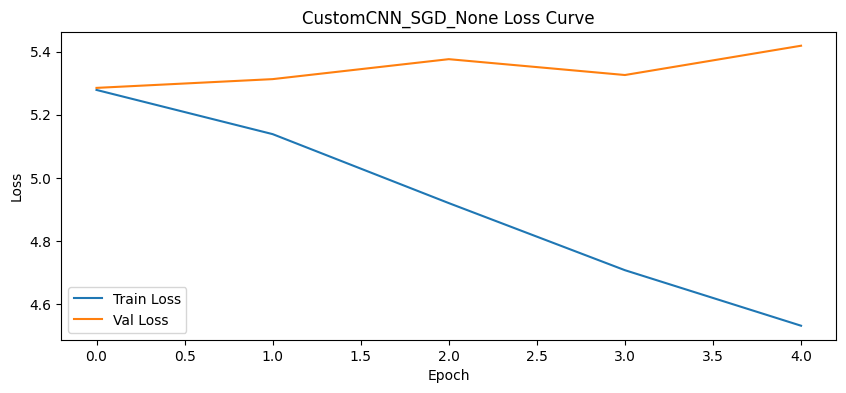

CustomCNN_SGD_None Train Acc: 0.1073, Val Acc: 0.0135


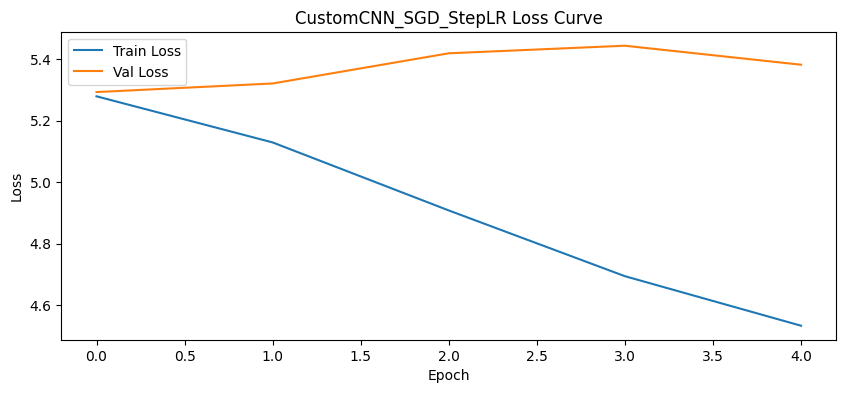

CustomCNN_SGD_StepLR Train Acc: 0.1051, Val Acc: 0.0158


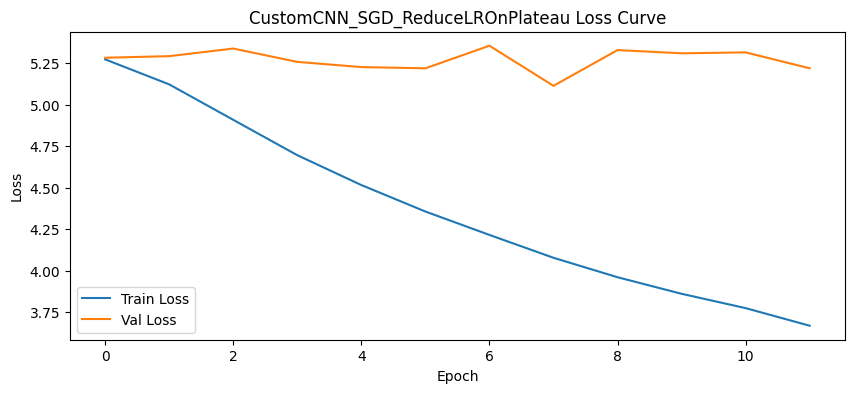

CustomCNN_SGD_ReduceLROnPlateau Train Acc: 0.2325, Val Acc: 0.0330


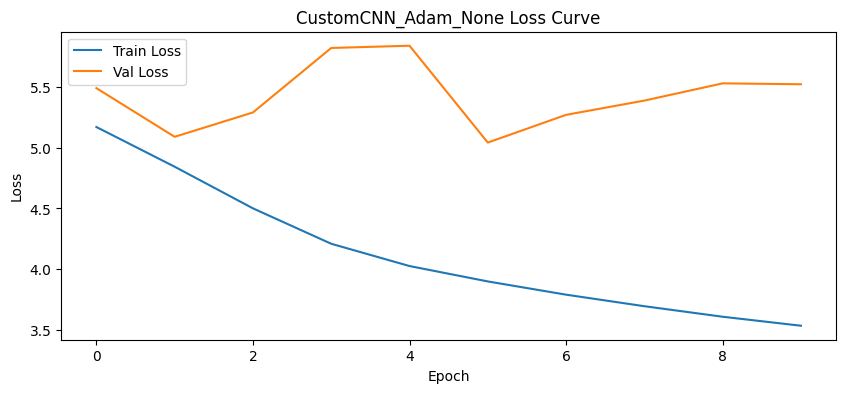

CustomCNN_Adam_None Train Acc: 0.2244, Val Acc: 0.0395


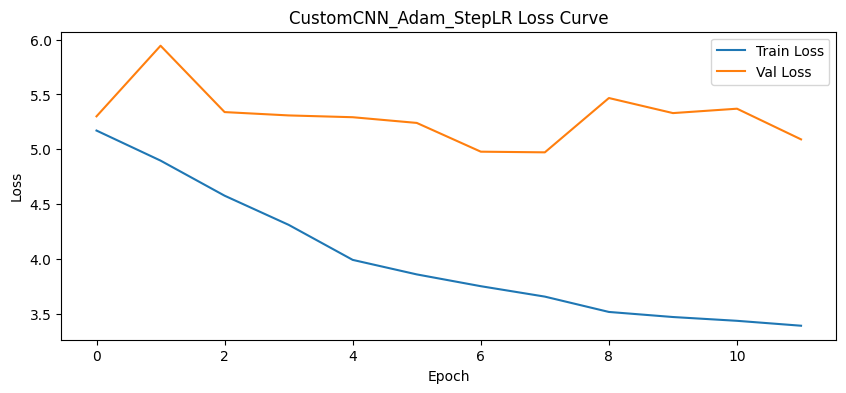

CustomCNN_Adam_StepLR Train Acc: 0.2793, Val Acc: 0.0607


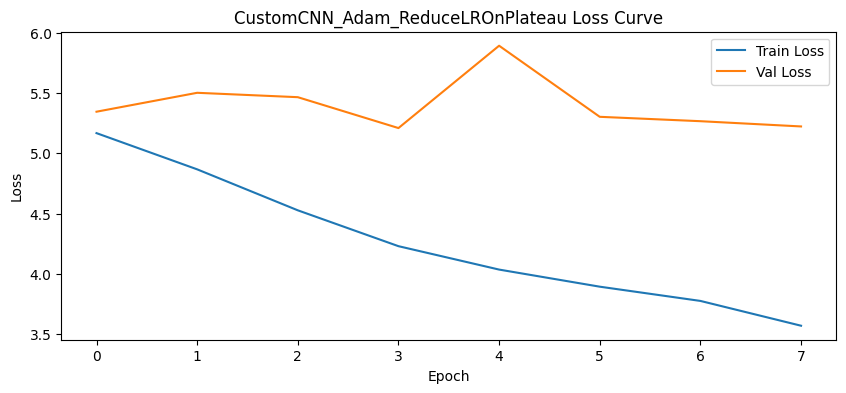

CustomCNN_Adam_ReduceLROnPlateau Train Acc: 0.2366, Val Acc: 0.0497


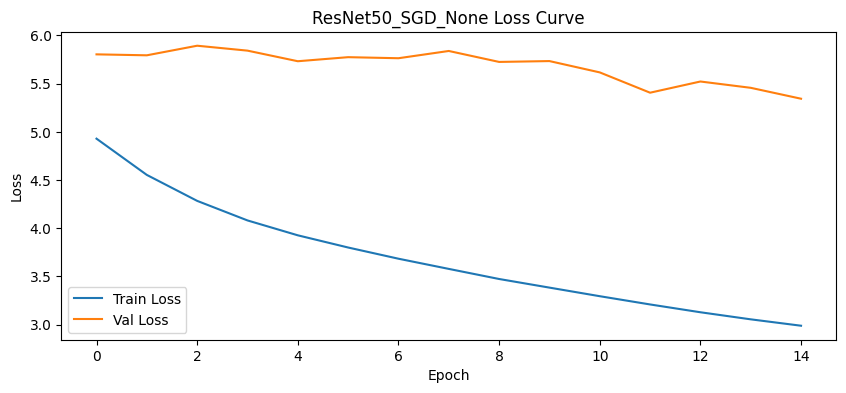

ResNet50_SGD_None Train Acc: 0.3330, Val Acc: 0.0444


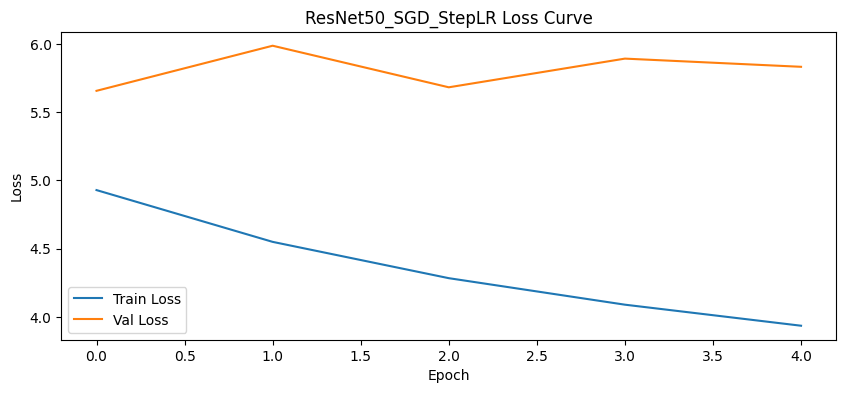

ResNet50_SGD_StepLR Train Acc: 0.1691, Val Acc: 0.0131


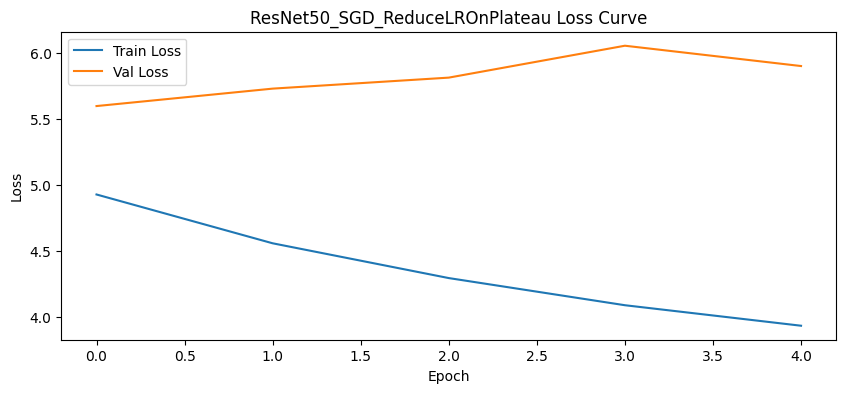

ResNet50_SGD_ReduceLROnPlateau Train Acc: 0.1704, Val Acc: 0.0136


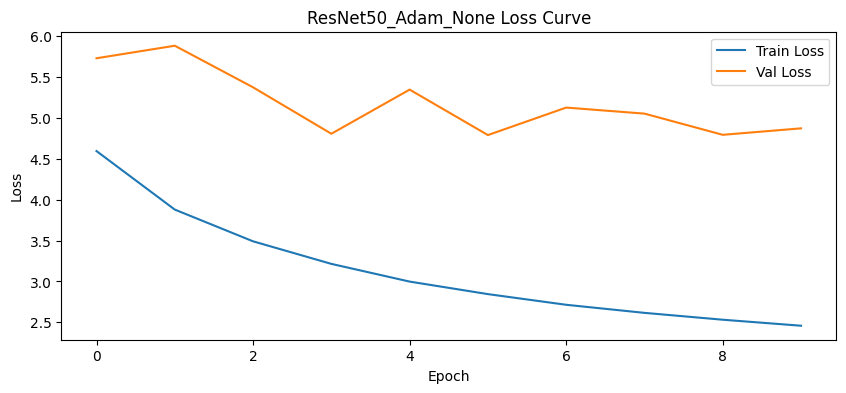

ResNet50_Adam_None Train Acc: 0.4349, Val Acc: 0.0880


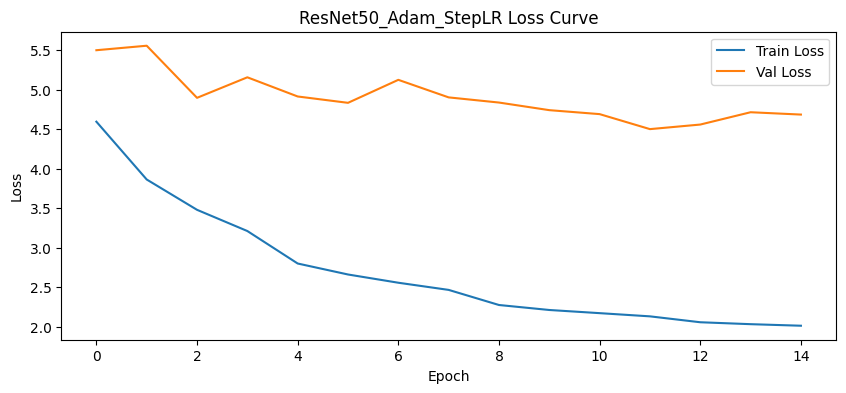

ResNet50_Adam_StepLR Train Acc: 0.5316, Val Acc: 0.1116


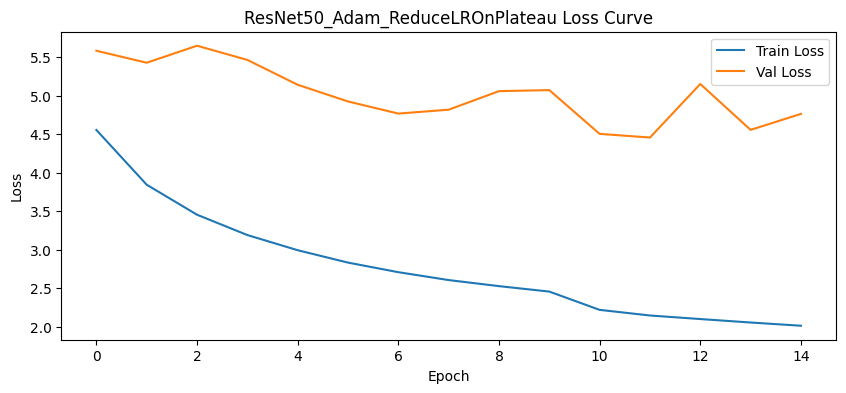

ResNet50_Adam_ReduceLROnPlateau Train Acc: 0.5372, Val Acc: 0.1142


In [23]:
for key, res in results.items():
    plt.figure(figsize=(10,4))
    plt.plot(res["train_losses"], label="Train Loss")
    plt.plot(res["val_losses"], label="Val Loss")
    plt.title(f"{key} Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    print(f"{key} Train Acc: {res['train_acc']:.4f}, Val Acc: {res['val_acc']:.4f}")


In [24]:
import pickle

# Save
with open("results.pkl", "wb") as f:
    pickle.dump(results, f)

# Load later
# with open("results.pkl", "rb") as f:
#     results = pickle.load(f)


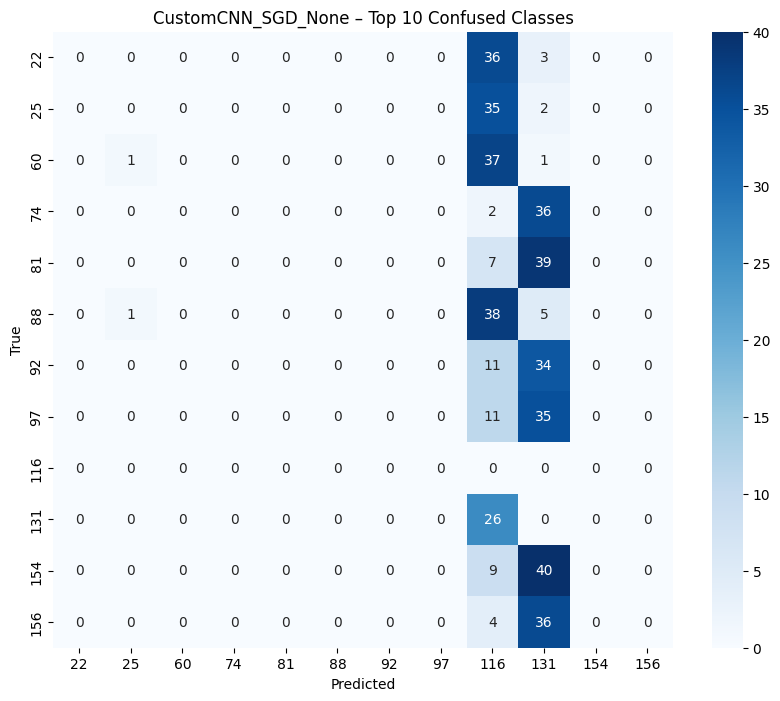

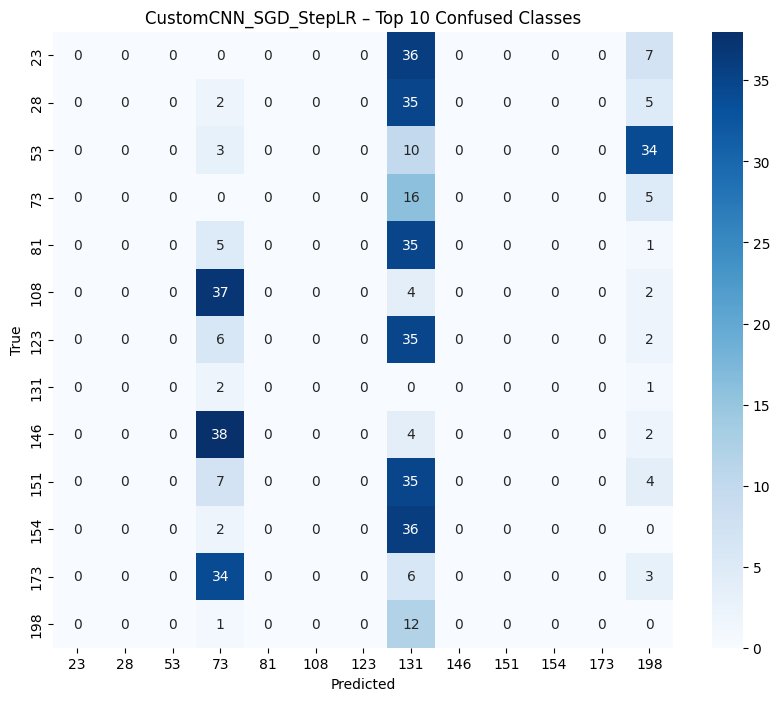

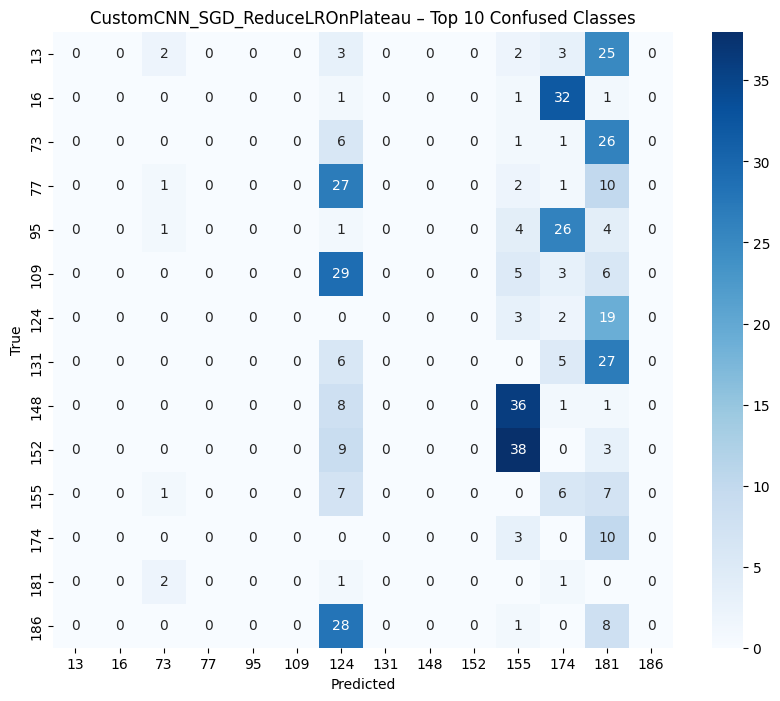

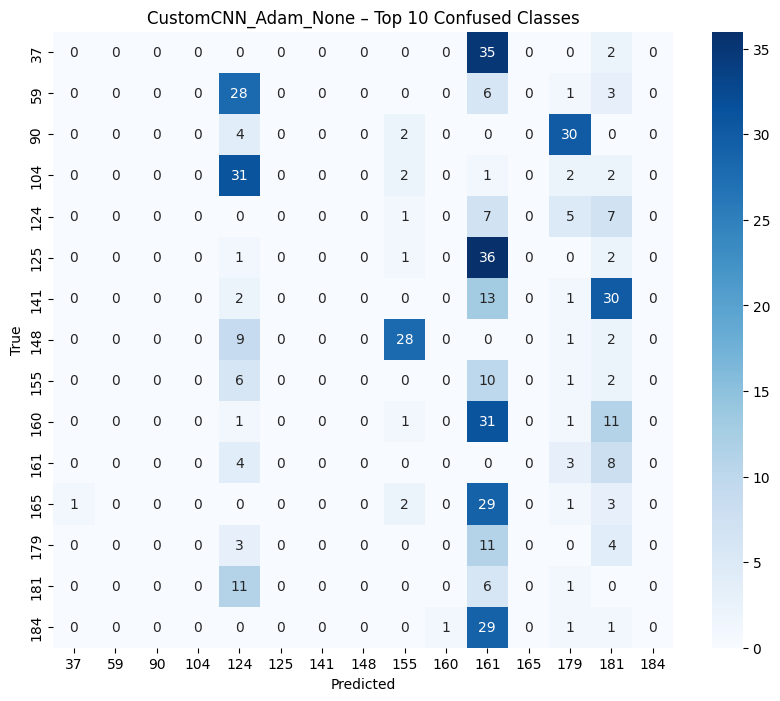

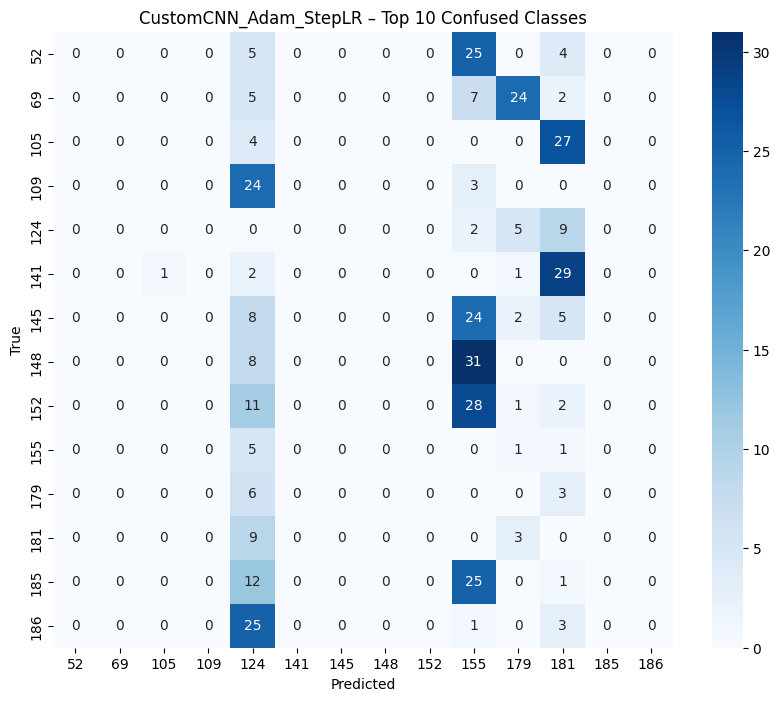

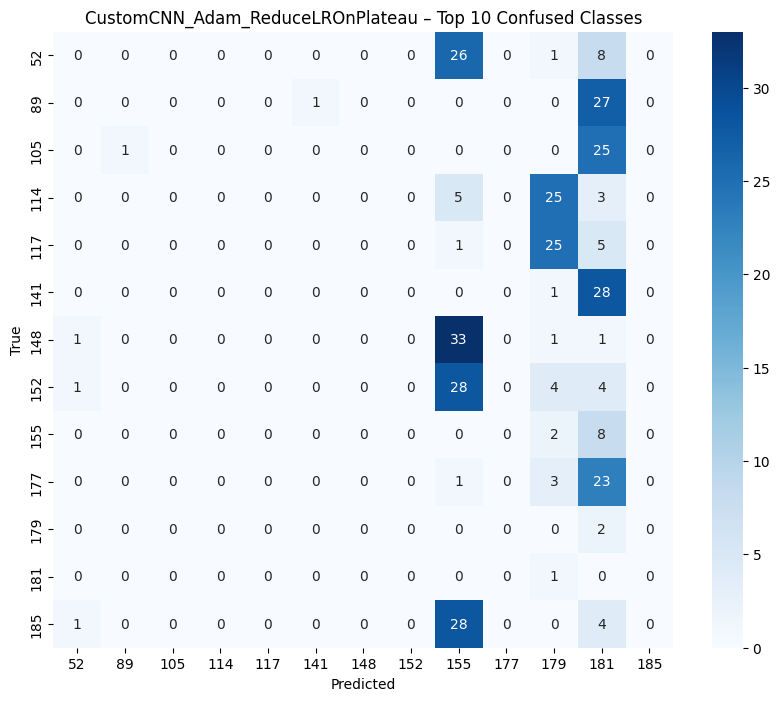

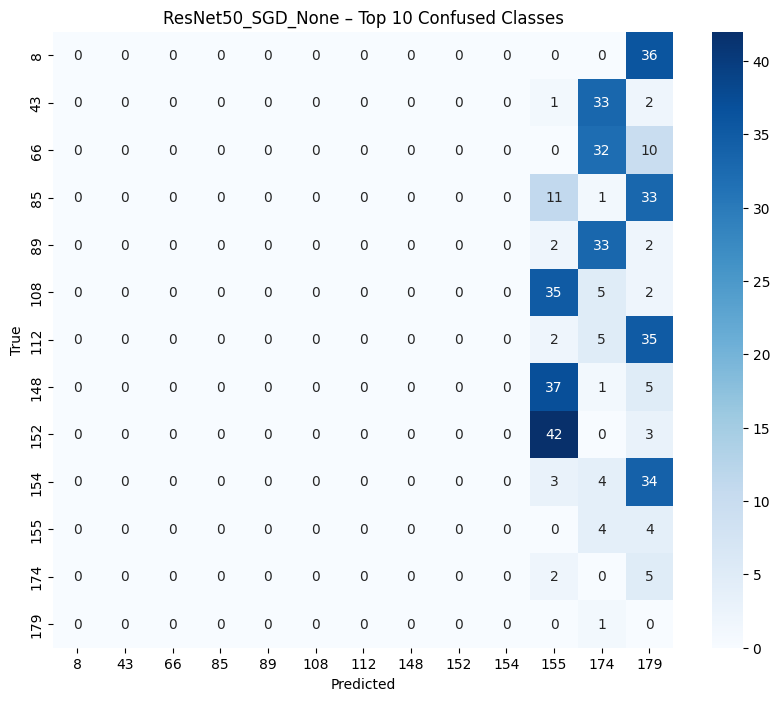

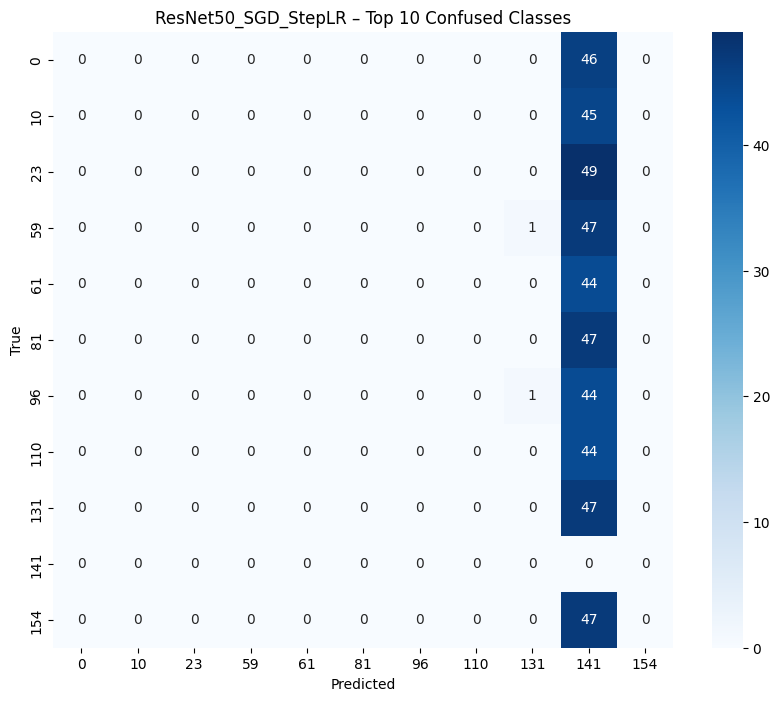

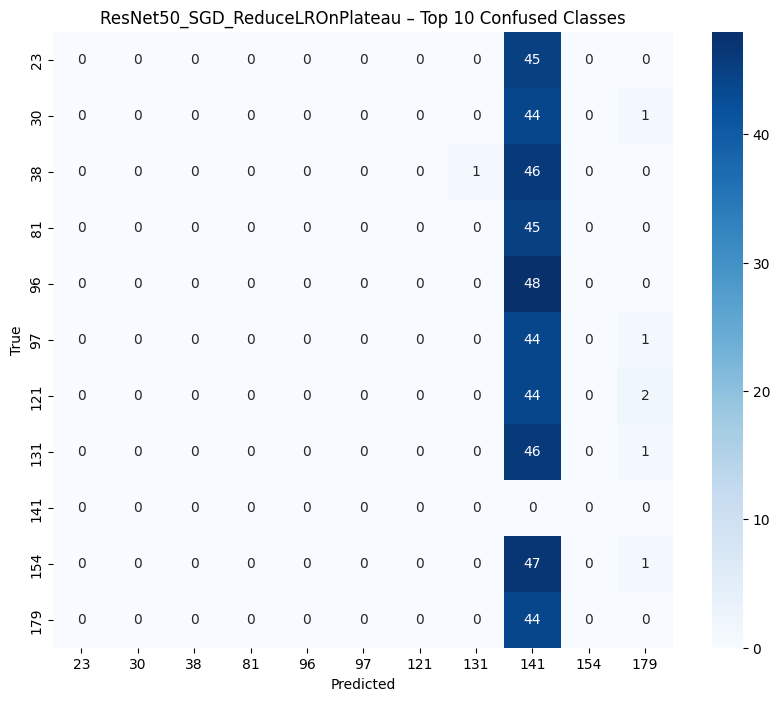

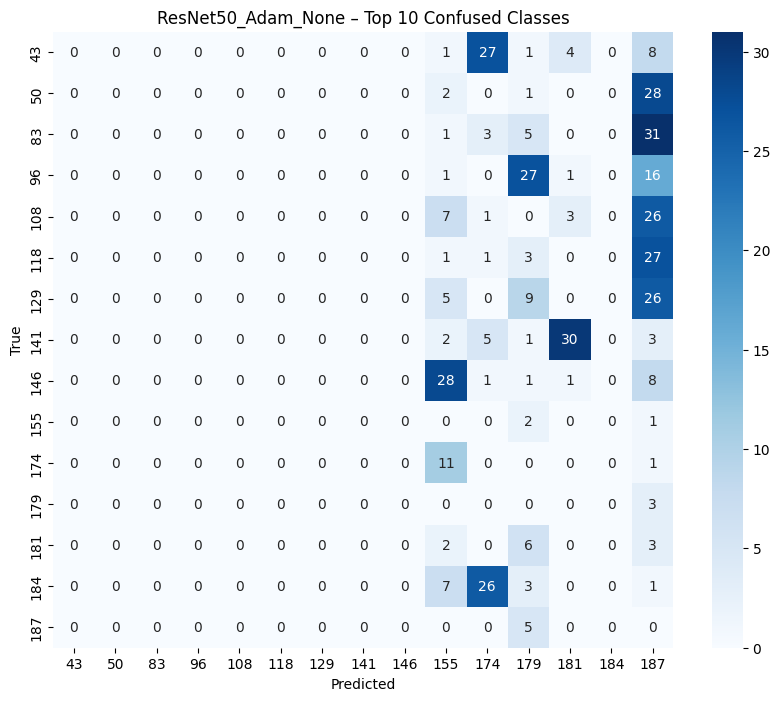

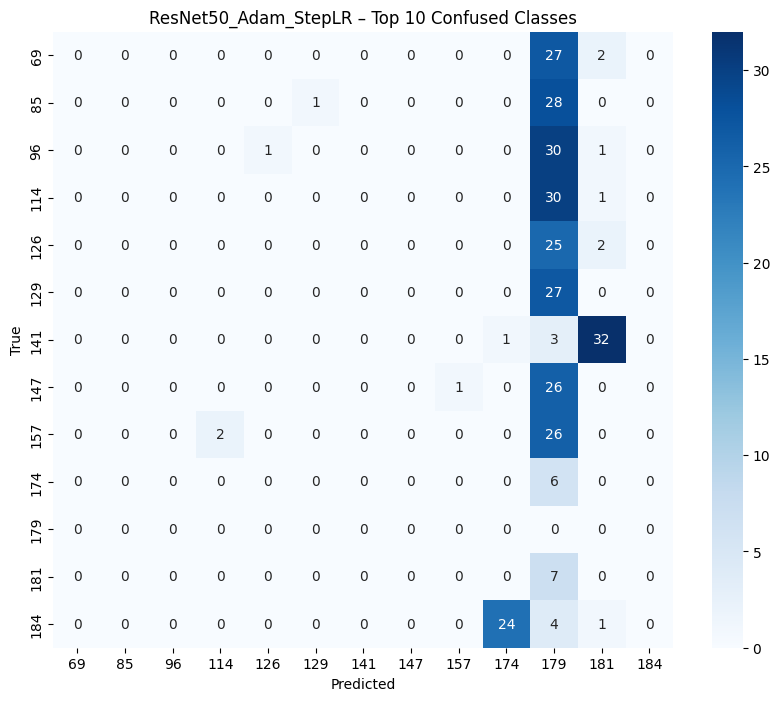

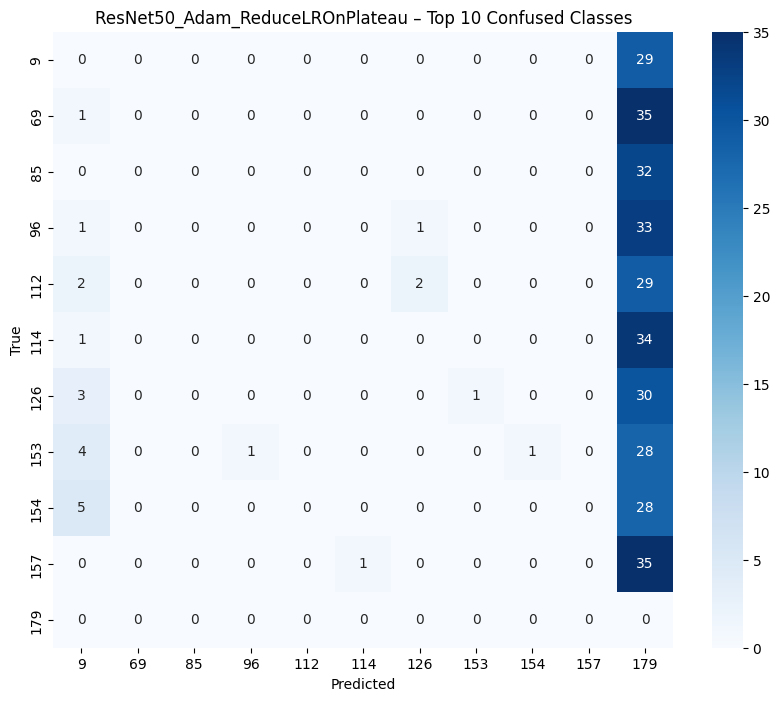

In [25]:
for key, res in results.items():
    cm = confusion_matrix(res["val_labels"], res["val_preds"])
    
    # zero out diagonal (correct predictions)
    np.fill_diagonal(cm, 0)

    # find top N most confused classes
    N = 10
    confused_pairs = np.dstack(np.unravel_index(np.argsort(cm.ravel())[::-1], cm.shape))[0][:N]
    
    top_true = [i for i, j in confused_pairs]
    top_pred = [j for i, j in confused_pairs]
    top_classes = sorted(set(top_true + top_pred))
    
    cm_small = cm[np.ix_(top_classes, top_classes)]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_small, annot=True, fmt="d", cmap="Blues",
                xticklabels=top_classes, yticklabels=top_classes)
    plt.title(f"{key} – Top {N} Confused Classes")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [26]:
best_cnn = best_models['CustomCNN']
best_resnet = best_models['ResNet50']

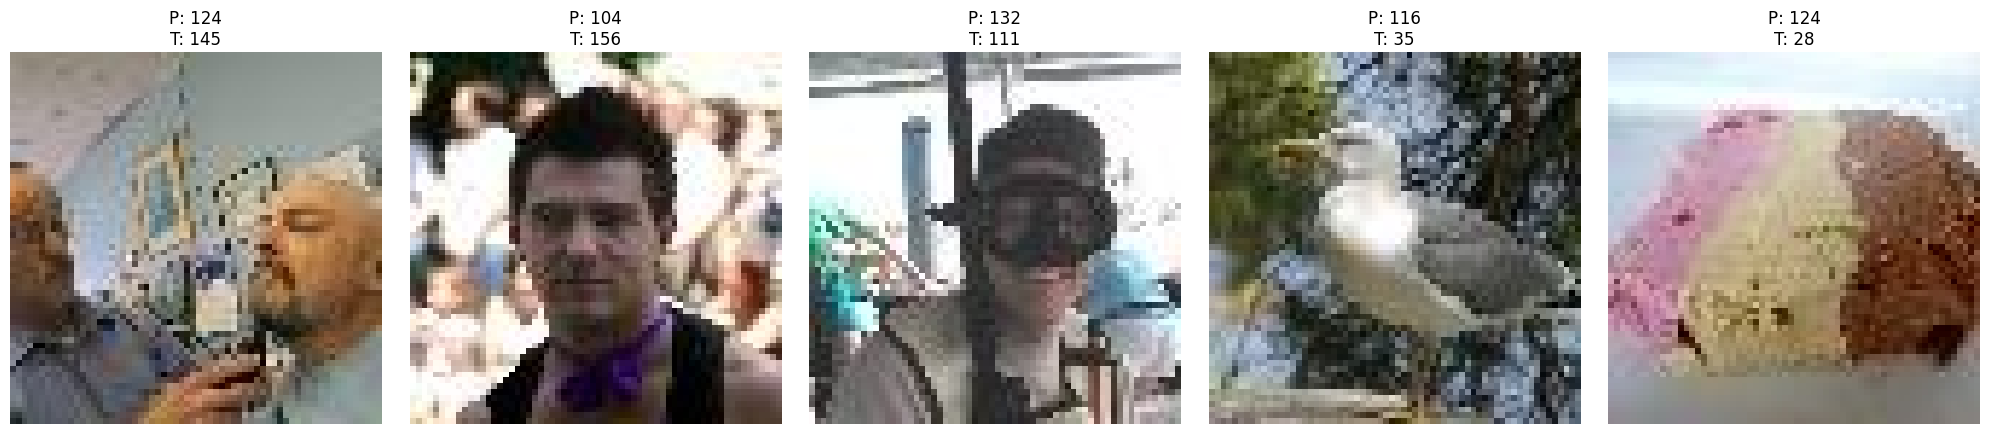

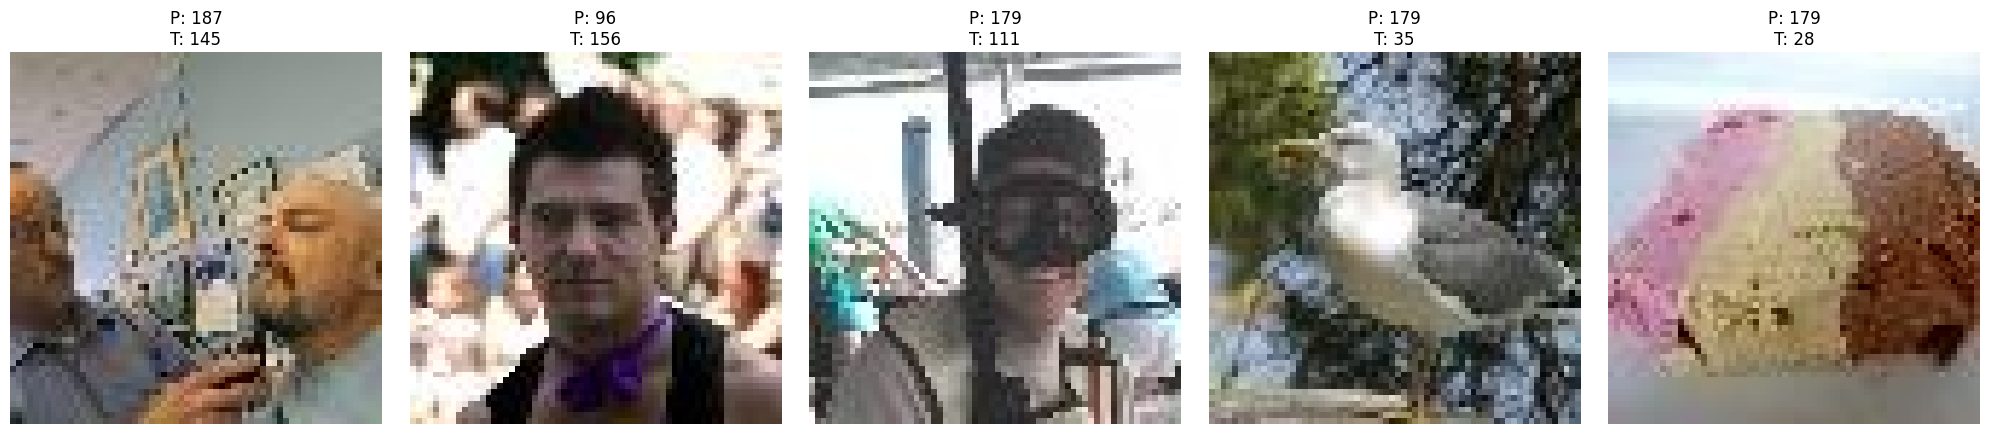

In [27]:
def show_misclassified(model, loader, device='cuda', num_images=5):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            mask = preds != labels
            if mask.sum() > 0:
                misclassified.extend([
                    (img.cpu(), pred.item(), label.item()) 
                    for img, pred, label in zip(images[mask], preds[mask], labels[mask])
                ])
            if len(misclassified) >= num_images:
                break

    # Create a figure with proper spacing
    fig, axes = plt.subplots(1, num_images, figsize=(4*num_images, 5))
    if num_images == 1:
        axes = [axes]  # make it iterable

    for i, (img, pred, label) in enumerate(misclassified[:num_images]):
        ax = axes[i]
        ax.imshow(np.transpose(img.numpy(), (1,2,0)))
        ax.set_title(f"P: {pred}\nT: {label}", fontsize=12)
        ax.axis("off")

    plt.tight_layout(w_pad=2)  # adjust spacing between images
    plt.show()


# Example
show_misclassified(best_cnn, val_loader, device)

show_misclassified(best_resnet, val_loader, device)

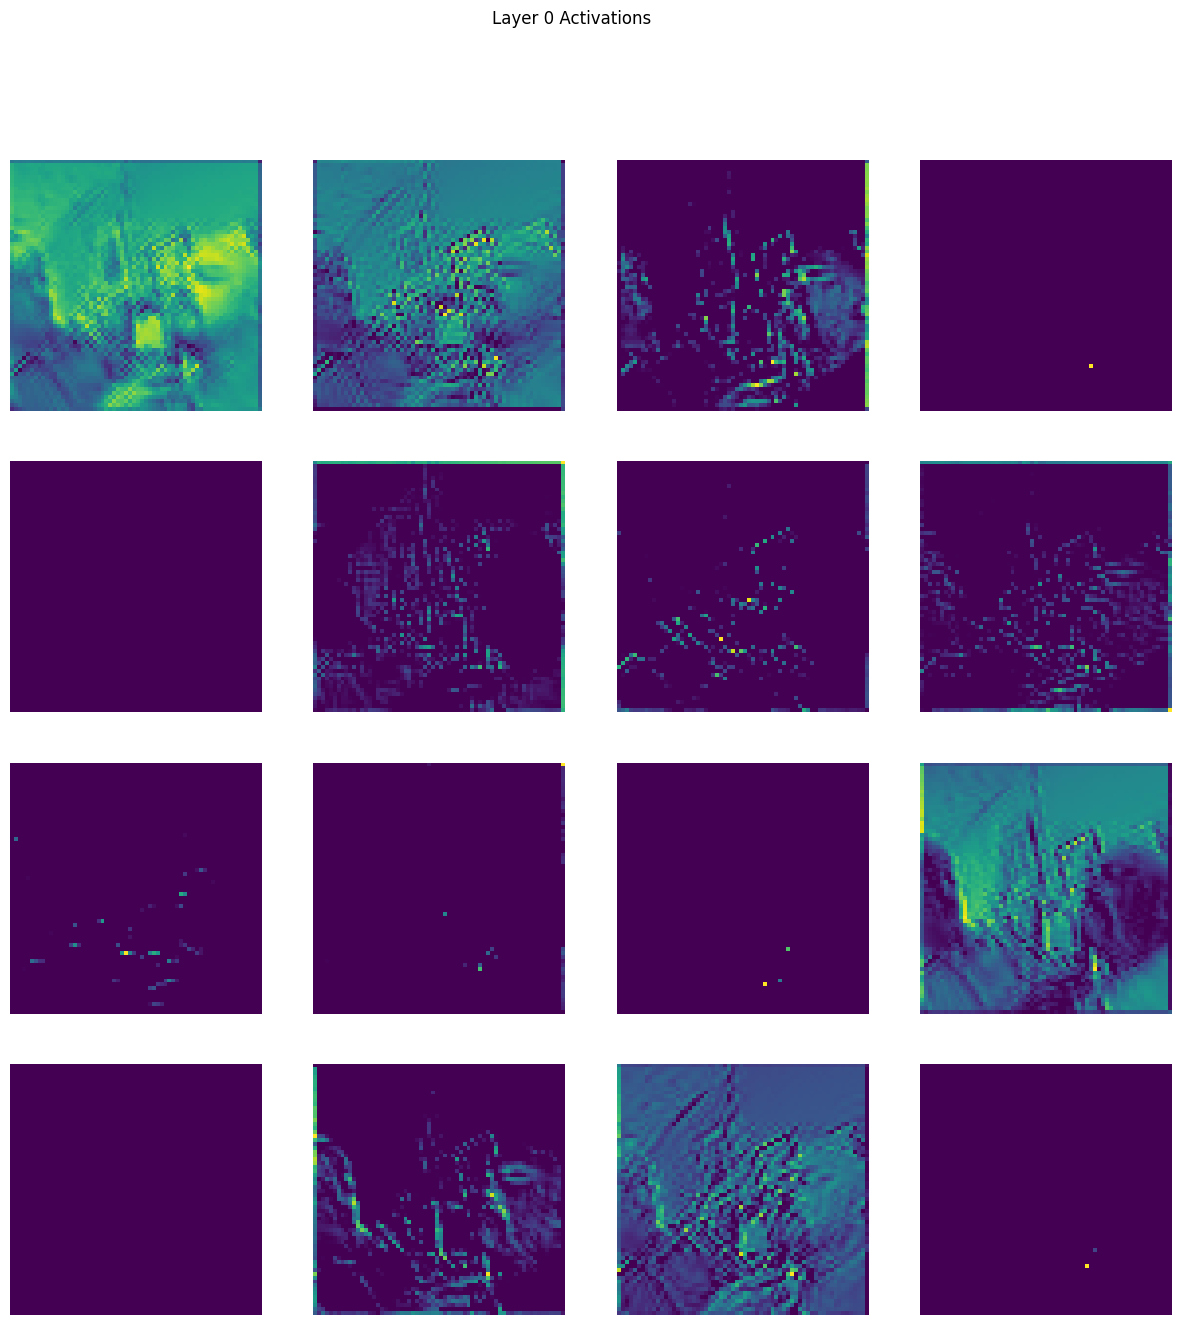

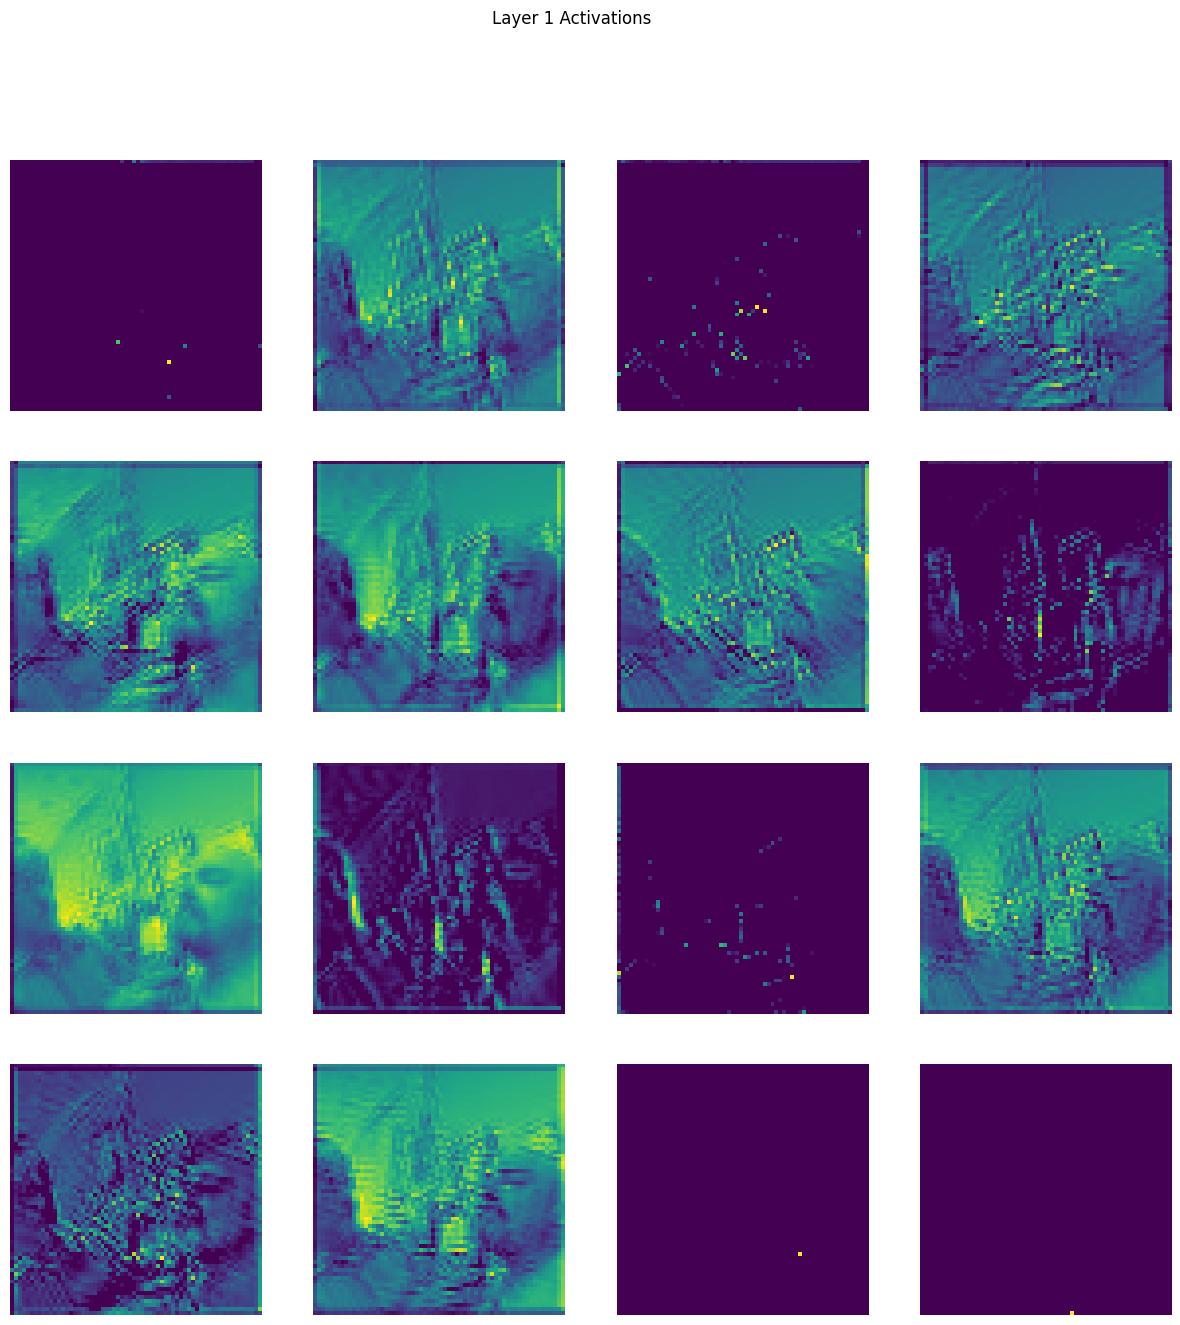

In [28]:
import torch.nn.functional as F

def visualize_activations(model, layer_indices, image, device='cuda'):
    model.eval()
    model.to(device)  # Ensure model is on the correct device
    x = image.unsqueeze(0).to(device)  # single image
    activations = []
    
    with torch.no_grad():  # Add this to save memory and speed up
        for i, layer in enumerate(model.network):
            x = layer(x)
            if i in layer_indices:
                activations.append(x.cpu())
    
    for i, act in enumerate(activations):
        n_features = act.shape[1]
        plt.figure(figsize=(15,15))
        for j in range(min(n_features, 16)):  # show first 16 channels
            plt.subplot(4,4,j+1)
            plt.imshow(act[0,j].detach().numpy(), cmap='viridis')
            plt.axis('off')
        plt.suptitle(f"Layer {layer_indices[i]} Activations")
        plt.show()

# Example: visualize layer1 and layer2
sample_img, _ = next(iter(val_loader))
visualize_activations(model_cnn, [0,1], sample_img[0], device)

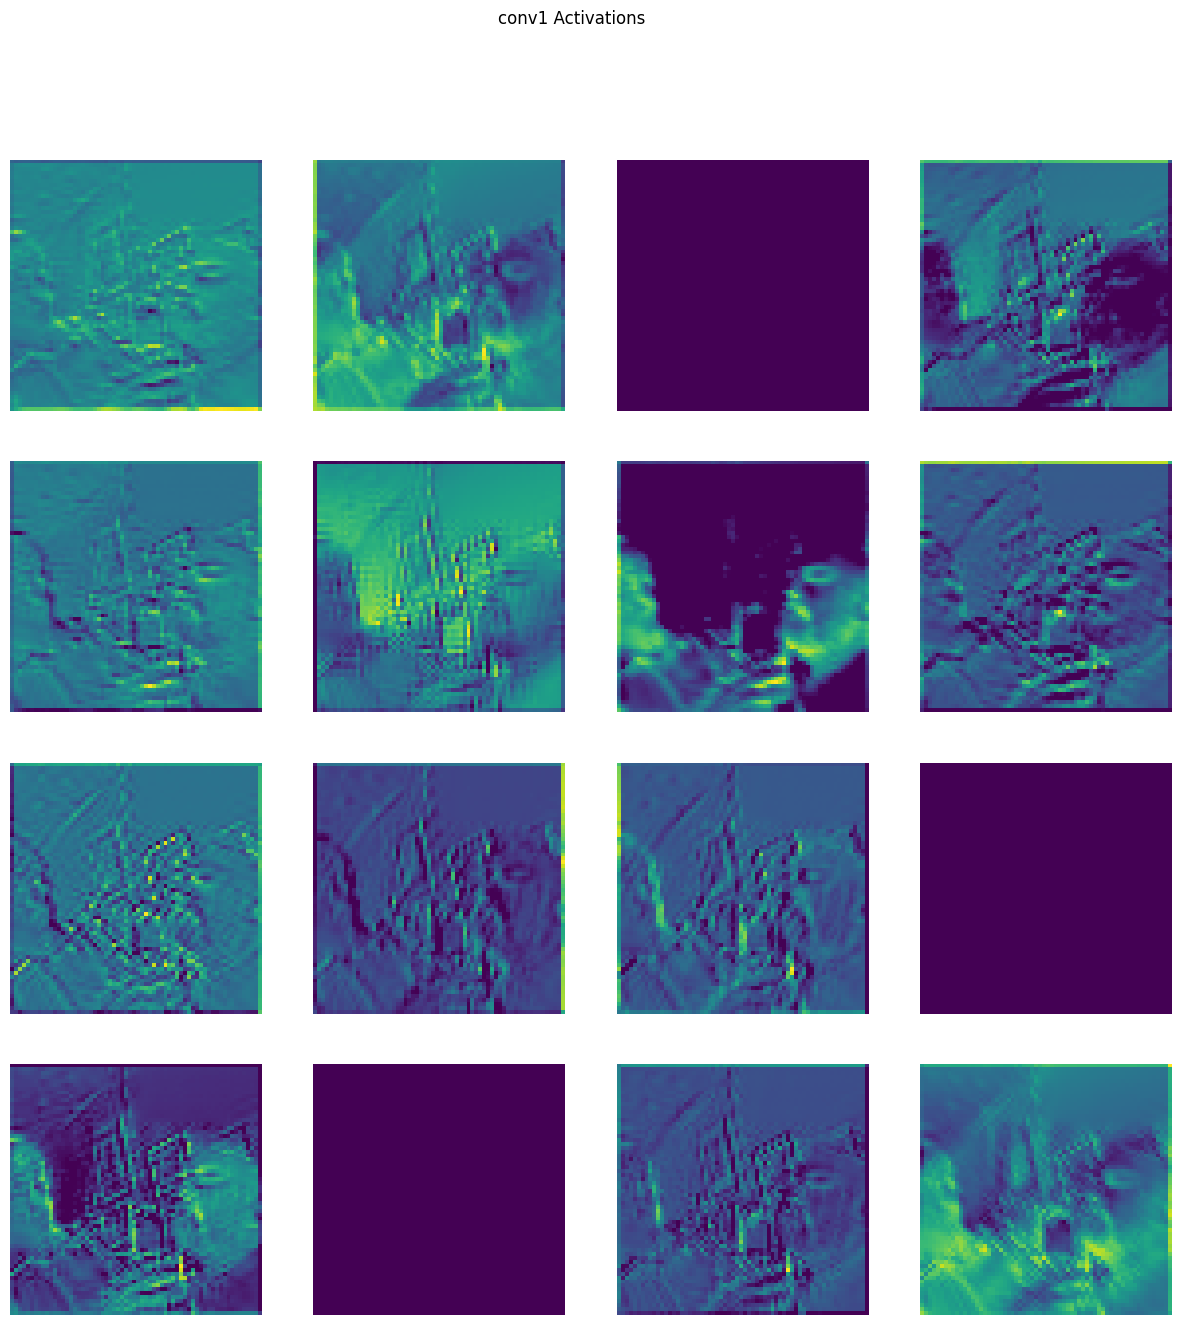

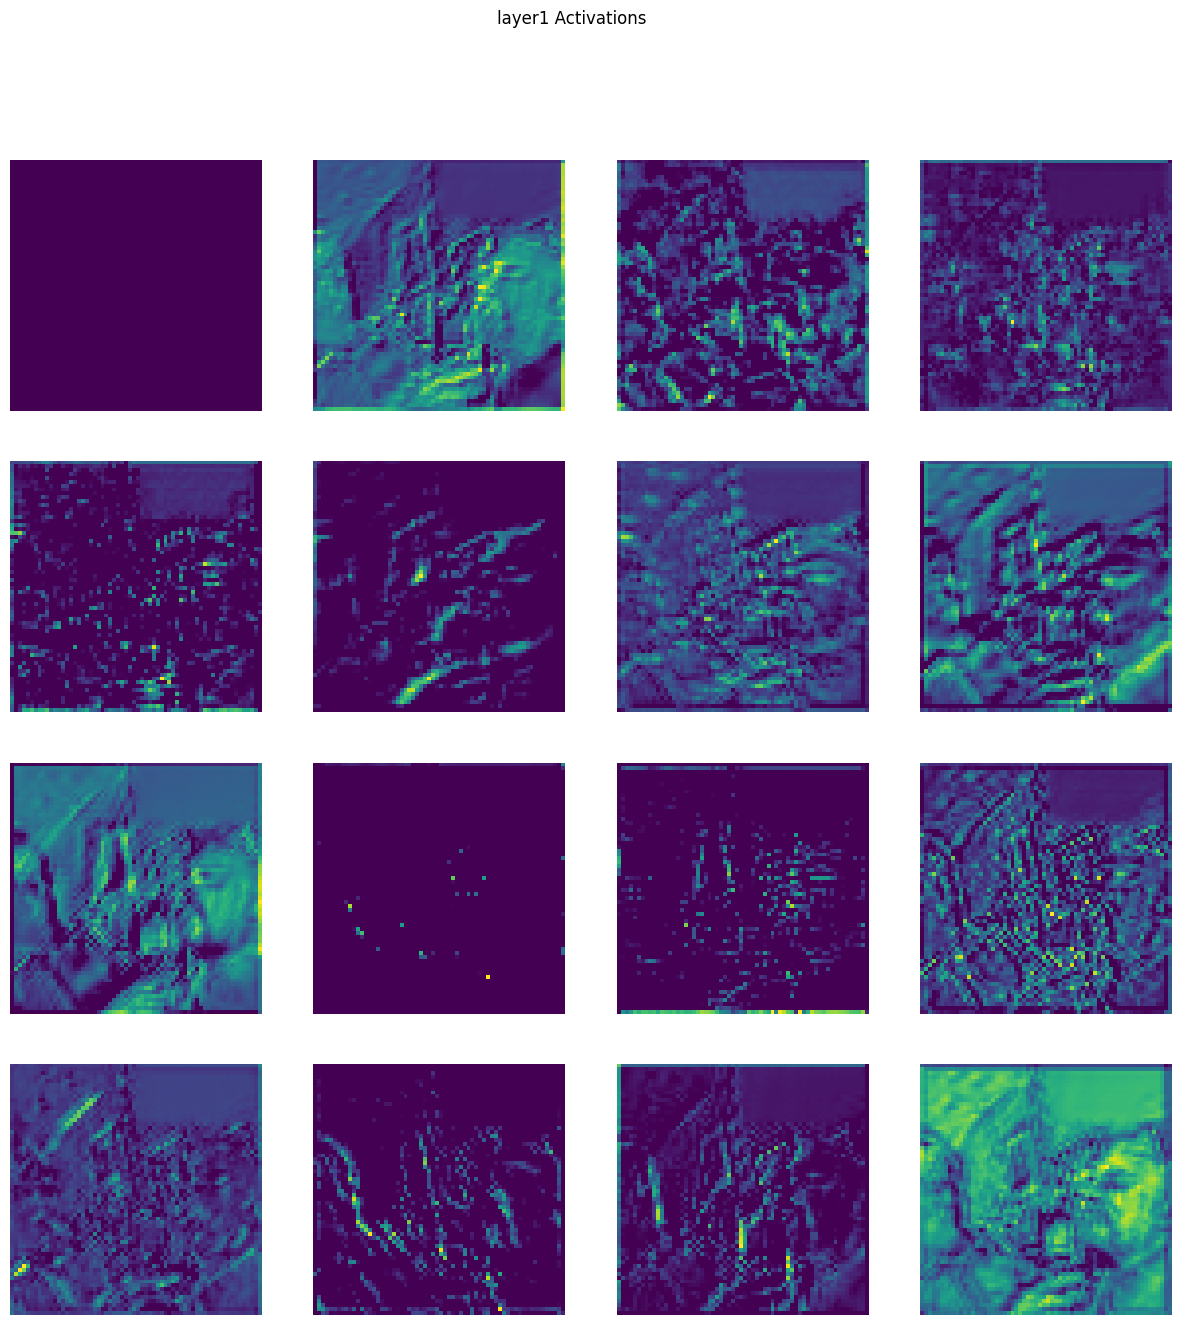

In [29]:
import torch
import matplotlib.pyplot as plt

def visualize_resnet_activations(model, layers_to_visualize, image, device='cuda'):
    """
    Visualize intermediate feature maps for given layers in a ResNet model.
    
    Args:
        model: ResNet model
        layers_to_visualize: list of layer names e.g. ['conv1', 'layer1', 'layer2']
        image: single image tensor (C, H, W)
        device: device to run on
    """
    model.eval()
    model.to(device)  # Ensure model is on the correct device
    x = image.unsqueeze(0).to(device)
    activations = {}

    # Forward pass manually through each key stage
    with torch.no_grad():
        x = model.relu(model.bn1(model.conv1(x)))
        if 'conv1' in layers_to_visualize:
            activations['conv1'] = x.cpu()

        x = model.layer1(x)
        if 'layer1' in layers_to_visualize:
            activations['layer1'] = x.cpu()

        x = model.layer2(x)
        if 'layer2' in layers_to_visualize:
            activations['layer2'] = x.cpu()

        x = model.layer3(x)
        if 'layer3' in layers_to_visualize:
            activations['layer3'] = x.cpu()

        x = model.layer4(x)
        if 'layer4' in layers_to_visualize:
            activations['layer4'] = x.cpu()

    # ---- Visualization ----
    for layer_name, act in activations.items():
        n_features = act.shape[1]
        plt.figure(figsize=(15, 15))
        for j in range(min(16, n_features)):
            plt.subplot(4, 4, j + 1)
            plt.imshow(act[0, j].detach().numpy(), cmap='viridis')
            plt.axis('off')
        plt.suptitle(f"{layer_name} Activations")
        plt.show()


visualize_resnet_activations(best_resnet, ['conv1', 'layer1'], sample_img[0], device)
